## Experiments for Intel Scene Classification challenge

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

import os
print(os.listdir("../input"))

['seg_train', 'seg_test', 'seg_pred']


In [2]:
pred = !ls ../input/seg_pred/seg_pred
len(pred)

7301

In [3]:
buildings = !ls ../input/seg_train/seg_train/buildings
forest = !ls ../input/seg_train/seg_train/forest
glacier = !ls ../input/seg_train/seg_train/glacier
mountain = !ls ../input/seg_train/seg_train/mountain
sea = !ls ../input/seg_train/seg_train/sea
street = !ls ../input/seg_train/seg_train/street

len(buildings) + len(forest) + len(glacier) + len(mountain) + len(sea) + len(street)

14034

In [4]:
buildings = !ls ../input/seg_test/seg_test/buildings
forest = !ls ../input/seg_test/seg_test/forest
glacier = !ls ../input/seg_test/seg_test/glacier
mountain = !ls ../input/seg_test/seg_test/mountain
sea = !ls ../input/seg_test/seg_test/sea
street = !ls ../input/seg_test/seg_test/street

len(buildings) + len(forest) + len(glacier) + len(mountain) + len(sea) + len(street)

3000

In [5]:
# Batches of 256
databunch = ImageDataBunch.from_folder(Path('../input'), ds_tfms=get_transforms(),
                               train='seg_train', valid='seg_test',
                                   size=64, bs=256).normalize(imagenet_stats)

In [6]:
# Add the test images to the DataBunch
test_img = ImageList.from_folder(path=Path('../input/seg_pred', folder='swg_pred'))
databunch.add_test(test_img)

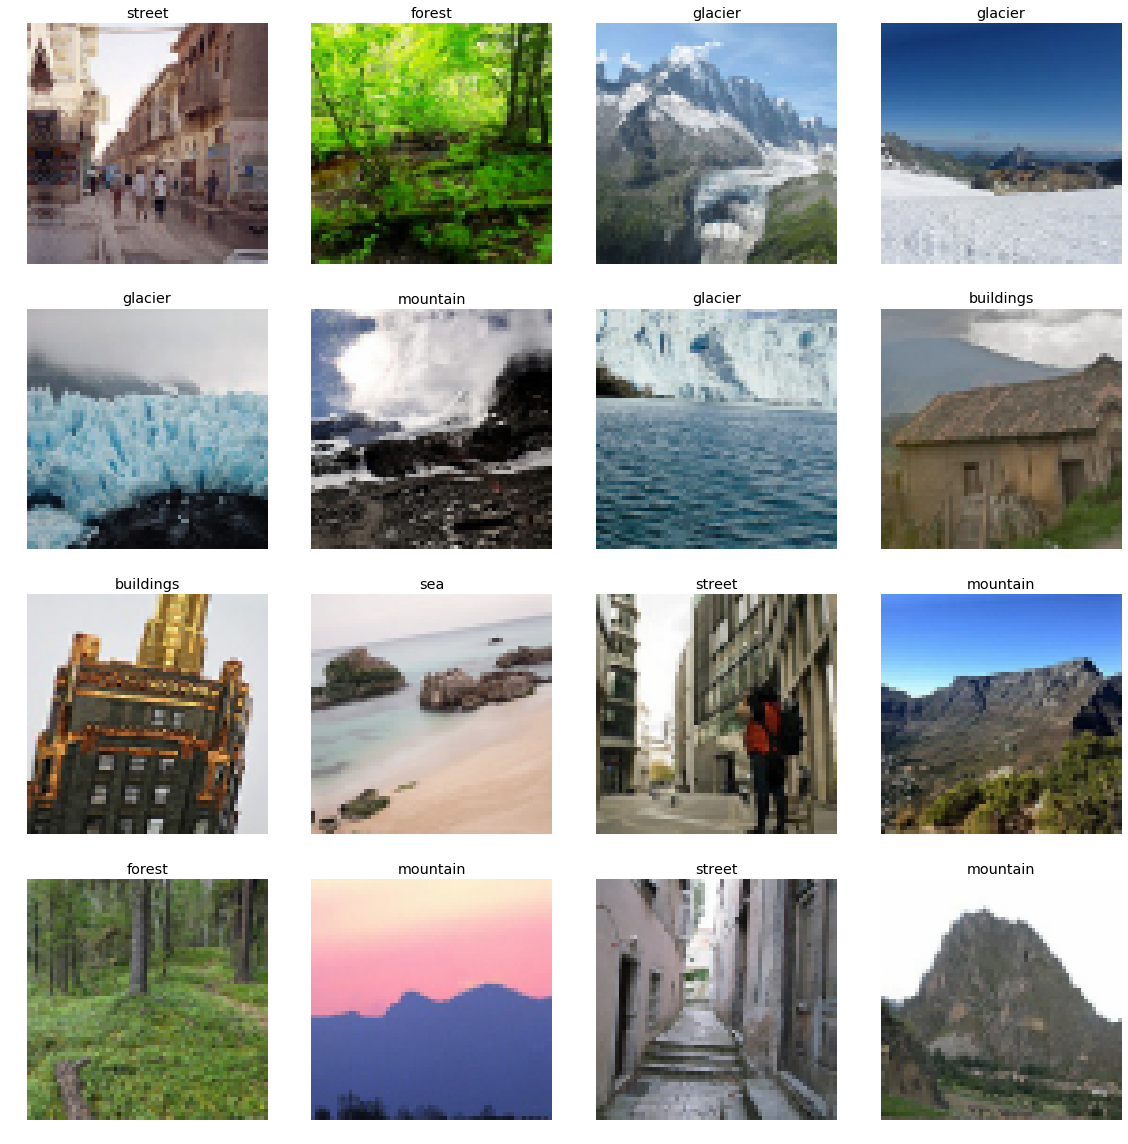

In [7]:
databunch.show_batch(rows=4)

In [8]:
databunch.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
databunch.label_list

LabelLists;

Train: LabelList (14034 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
forest,forest,forest,forest,forest
Path: ../input;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
forest,forest,forest,forest,forest
Path: ../input;

Test: LabelList (7301 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: ../input

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 30153845.11it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


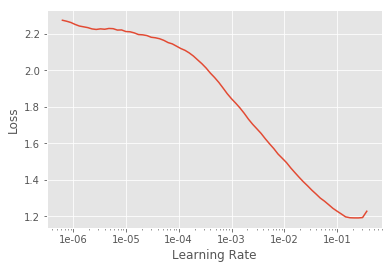

In [10]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy, model_dir='/tmp/models')
learner.lr_find();
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.716487,0.549543,0.804000,00:45
1,0.564685,0.414675,0.854667,00:43
2,0.454231,0.342428,0.874667,00:42
3,0.374455,0.330631,0.878000,00:44
4,0.328717,0.312292,0.886000,00:41


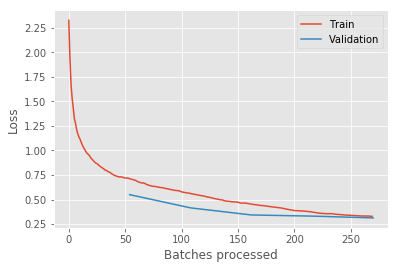

In [11]:
# Crazy story of learning rates you see :P
learner.fit_one_cycle(5, max_lr=(2e-04, 1e-03, 3*1e-02))
learner.recorder.plot_losses()

In [12]:
del learner
gc.collect()

9945

In [13]:
# Towards a more stable training
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(5, max_lr=slice(1e-02, 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,1.030435,0.505752,0.828333,00:47
1,0.584264,0.354210,0.874333,00:41
2,0.421888,0.302687,0.894667,00:43
3,0.334277,0.264250,0.907000,00:42
4,0.286338,0.262266,0.909000,00:43


Slightly overfits!

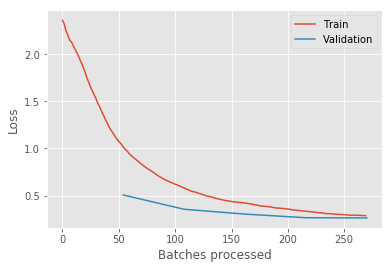

In [14]:
learner.recorder.plot_losses()

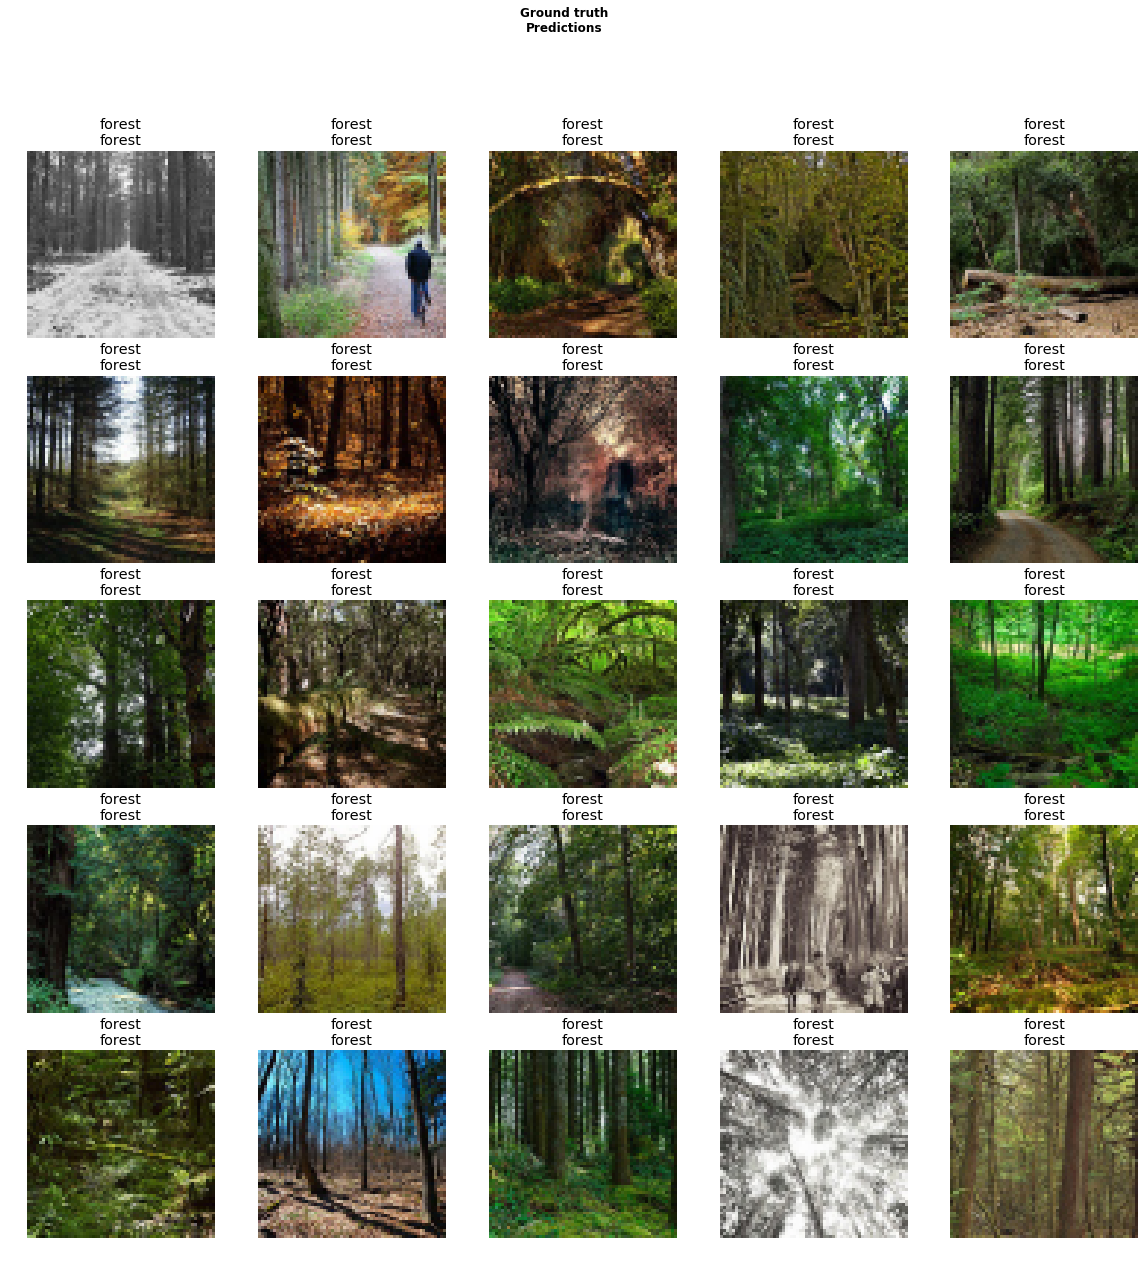

In [15]:
learner.show_results(ds_type=DatasetType.Valid)

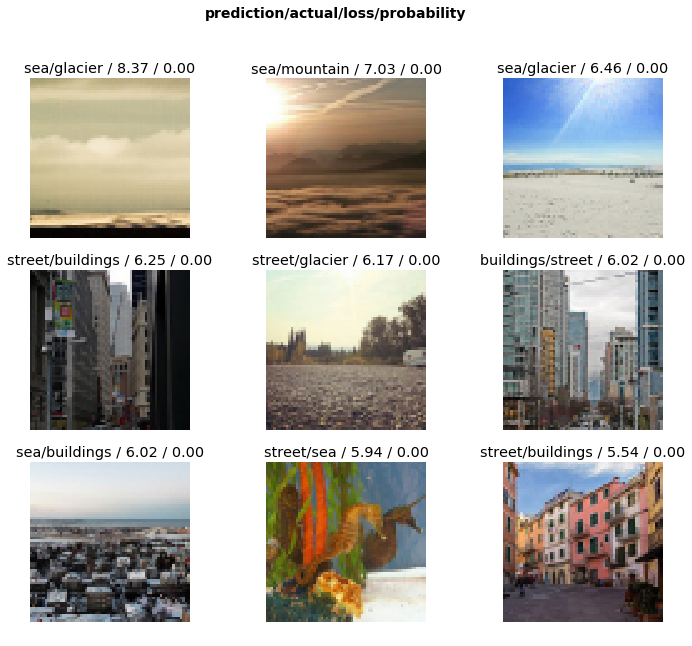

In [16]:
interp = ClassificationInterpretation.from_learner(learner.to_fp32())
interp.plot_top_losses(9, figsize=(12,10))

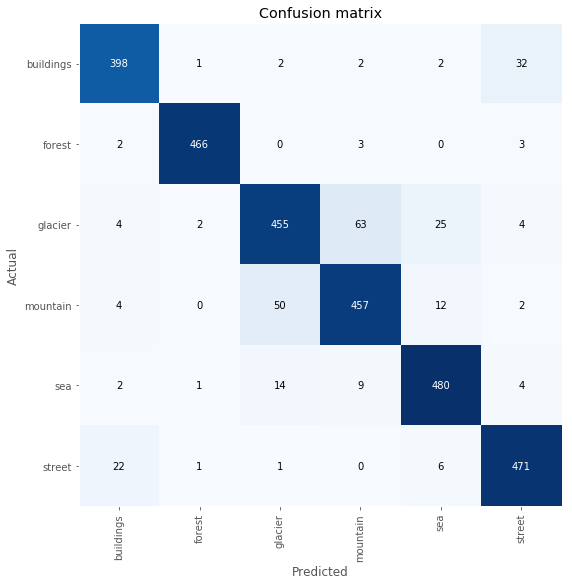

In [17]:
interp.plot_confusion_matrix(figsize=(8,8))

In [18]:
del learner
gc.collect()

3026

epoch,train_loss,valid_loss,accuracy,time
0,1.241951,0.550008,0.808000,00:45
1,0.691027,0.371377,0.871000,00:42
2,0.471869,0.360758,0.870000,00:44
3,0.380361,0.377844,0.868667,00:42
4,0.326385,0.276491,0.906000,00:43
5,0.277142,0.263667,0.904333,00:41
6,0.251779,0.256263,0.909333,00:43
7,0.229411,0.244781,0.911667,00:44
8,0.205466,0.231411,0.917333,00:43
9,0.194157,0.231151,0.918667,00:44


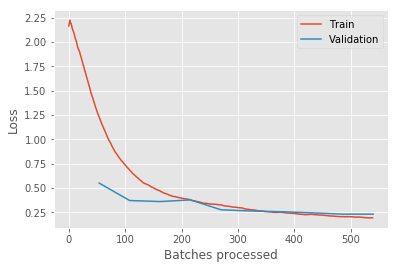

In [19]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

In [20]:
del learner
gc.collect()

2841

## A bit more data augmentation

In [21]:
new_transforms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)

In [22]:
# Batches of 256
new_databunch = ImageDataBunch.from_folder(Path('../input'), ds_tfms=new_transforms,
                               train='seg_train', valid='seg_test',
                                   size=64, bs=256).normalize(imagenet_stats)

new_databunch.add_test(test_img)

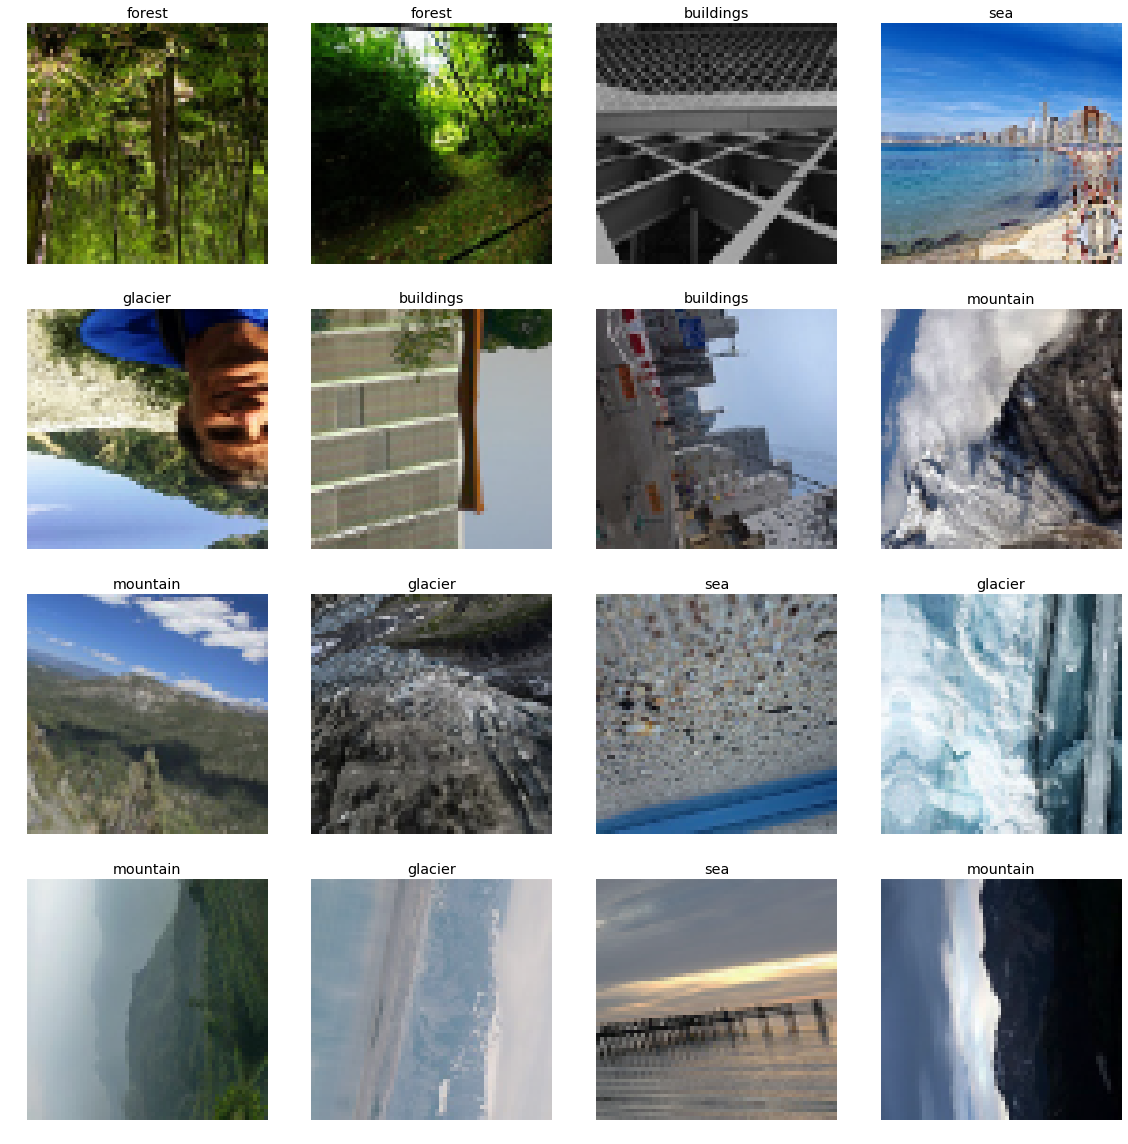

In [23]:
new_databunch.show_batch(rows=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.377329,0.664234,0.751000,00:43
1,0.855984,0.561500,0.808000,00:42
2,0.650059,0.667178,0.761000,00:44
3,0.526164,0.428866,0.840667,00:42
4,0.469400,0.376433,0.851667,00:44
5,0.422185,0.341561,0.875000,00:43
6,0.383996,0.296692,0.894000,00:44
7,0.355926,0.292875,0.894667,00:44
8,0.340869,0.288473,0.898333,00:43
9,0.334368,0.289813,0.896000,00:42


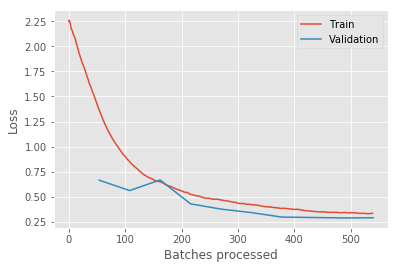

In [24]:
learner = cnn_learner(new_databunch, models.resnet50, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

It overfits after augmentation. The augmented transforms were may be way to much. 

In [25]:
del learner
gc.collect()

34328

In [26]:
less_transforms = get_transforms(do_flip=True, max_warp=0.3, max_zoom=0.05)

In [27]:
# Batches of 256
new_databunch_2 = ImageDataBunch.from_folder(Path('../input'), ds_tfms=less_transforms,
                               train='seg_train', valid='seg_test',
                                   size=64, bs=256).normalize(imagenet_stats)

new_databunch_2.add_test(test_img)

epoch,train_loss,valid_loss,accuracy,time
0,1.286526,0.550967,0.810000,00:42
1,0.727633,0.384791,0.864000,00:43
2,0.512502,0.347463,0.878667,00:41
3,0.398942,0.359342,0.869333,00:43
4,0.337280,0.316355,0.884333,00:44
5,0.299314,0.273062,0.907667,00:43
6,0.269413,0.275664,0.903333,00:41
7,0.245957,0.236631,0.917667,00:43
8,0.219677,0.235611,0.918333,00:41
9,0.207987,0.234358,0.919667,00:43


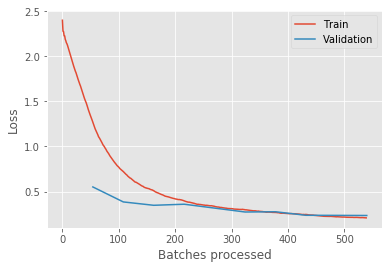

In [28]:
learner = cnn_learner(new_databunch_2, models.resnet50, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

Class performance right here.

In [29]:
learner.save('stage-1-rn50')

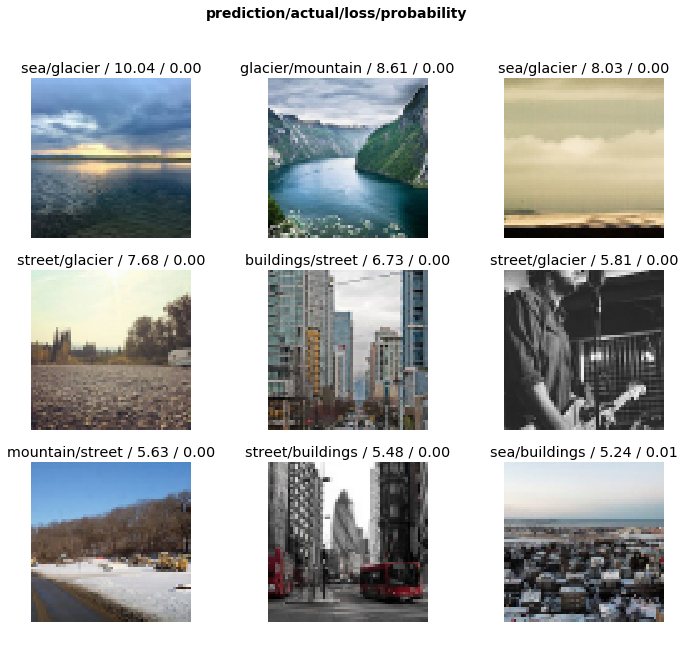

In [30]:
interp = ClassificationInterpretation.from_learner(learner.to_fp32())
interp.plot_top_losses(9, figsize=(12,10))

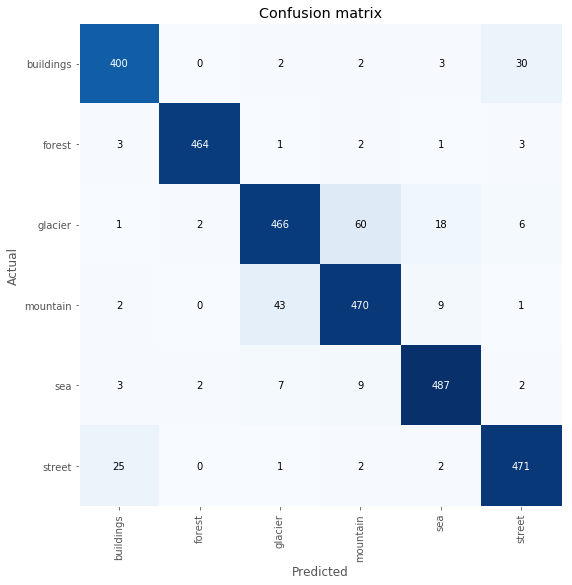

In [31]:
interp.plot_confusion_matrix(figsize=(8,8))

In [32]:
del learner
gc.collect()

19028

epoch,train_loss,valid_loss,accuracy,time
0,1.352015,0.654828,0.770000,00:41
1,0.797932,0.404249,0.858000,00:44
2,0.542048,0.357196,0.875333,00:42
3,0.426287,0.337752,0.885667,00:41
4,0.356962,0.306972,0.885667,00:43
5,0.320943,0.292328,0.901333,00:41
6,0.289596,0.266031,0.904333,00:42
7,0.268477,0.270135,0.904000,00:41
8,0.249533,0.261031,0.910333,00:44
9,0.235056,0.239164,0.914667,00:41


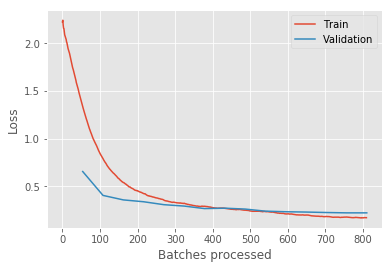

In [33]:
learner = cnn_learner(new_databunch_2, models.resnet50, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(15, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

Overfits slightly.

In [34]:
learner.save('stage-2-rn50')

In [35]:
del learner
gc.collect()

2703

## Trying deeper architectures

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:03, 58868170.67it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


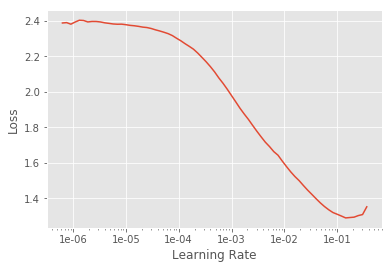

In [36]:
learner = cnn_learner(new_databunch_2, models.resnet101, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.064390,0.445369,0.851000,00:43
1,0.589293,0.335630,0.883667,00:44
2,0.412531,0.291578,0.901667,00:43
3,0.322550,0.253853,0.915333,00:44
4,0.277399,0.248336,0.911333,00:43


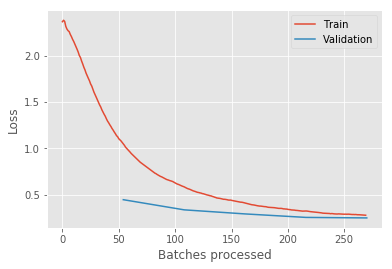

In [37]:
learner.fit_one_cycle(5, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

In [38]:
del learner
gc.collect()

9637

epoch,train_loss,valid_loss,accuracy,time
0,1.259591,0.572923,0.799667,00:44
1,0.691786,0.364229,0.870667,00:46
2,0.480376,0.358337,0.872333,00:42
3,0.373975,0.279501,0.894000,00:44
4,0.322383,0.302062,0.893667,00:42
5,0.281387,0.264987,0.900667,00:44
6,0.250110,0.263543,0.914000,00:42
7,0.226563,0.227559,0.917000,00:45
8,0.201608,0.215965,0.922333,00:45
9,0.187815,0.214514,0.921667,00:43


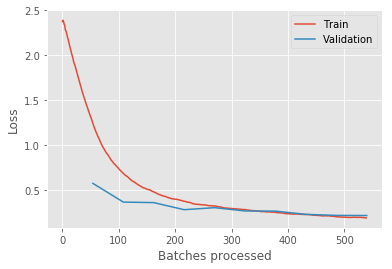

In [39]:
learner = cnn_learner(new_databunch_2, models.resnet101, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

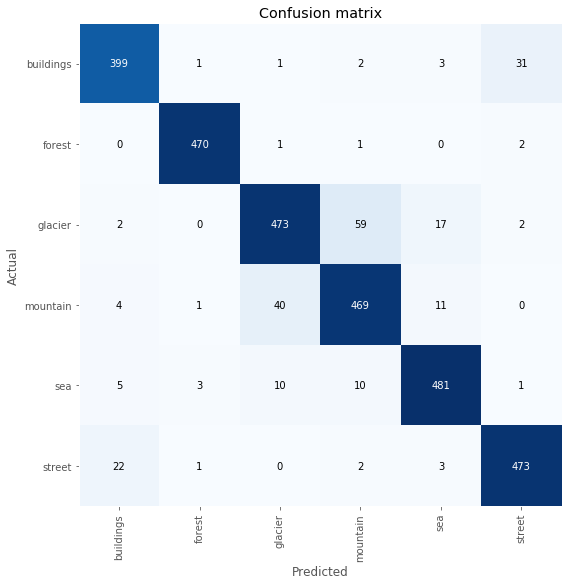

In [40]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(8,8))

In [41]:
learner.save('stage-1-rn101')

In [42]:
del learner
gc.collect()

5528

## Loading data in a larger size

In [43]:
# Size of 150*150
new_databunch_3 = ImageDataBunch.from_folder(Path('../input'), ds_tfms=less_transforms,
                               train='seg_train', valid='seg_test',
                                   size=150, bs=256).normalize(imagenet_stats)

new_databunch_3.add_test(test_img)

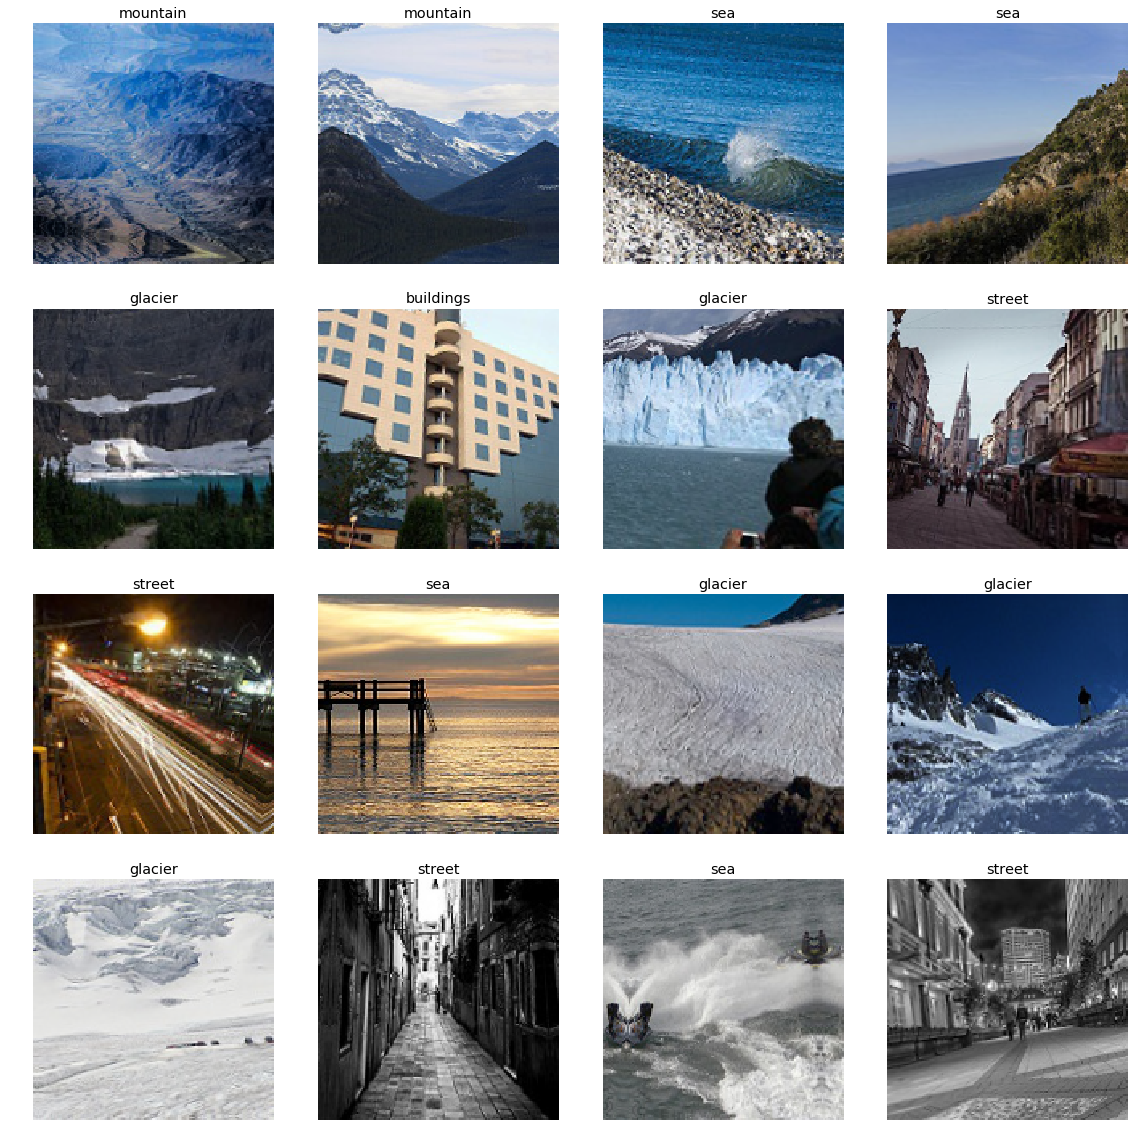

In [44]:
new_databunch_3.show_batch(rows=4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


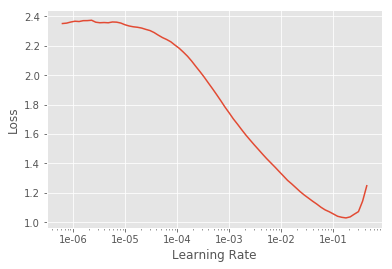

In [45]:
learner = cnn_learner(new_databunch_3, models.resnet101, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.lr_find();
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.832822,0.285160,0.896333,01:09
1,0.418905,0.225671,0.920333,01:10
2,0.290393,0.227312,0.920333,01:08
3,0.235163,0.202477,0.927000,01:08
4,0.198746,0.237256,0.917667,01:08
5,0.176864,0.182759,0.932333,01:08
6,0.146761,0.192129,0.933667,01:09
7,0.123835,0.172886,0.945333,01:06
8,0.105140,0.174117,0.945667,01:08
9,0.091883,0.175009,0.945333,01:08


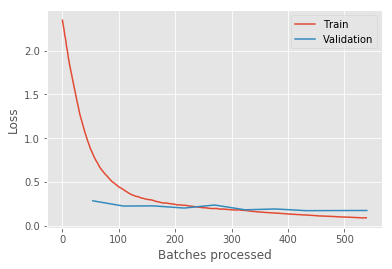

In [46]:
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

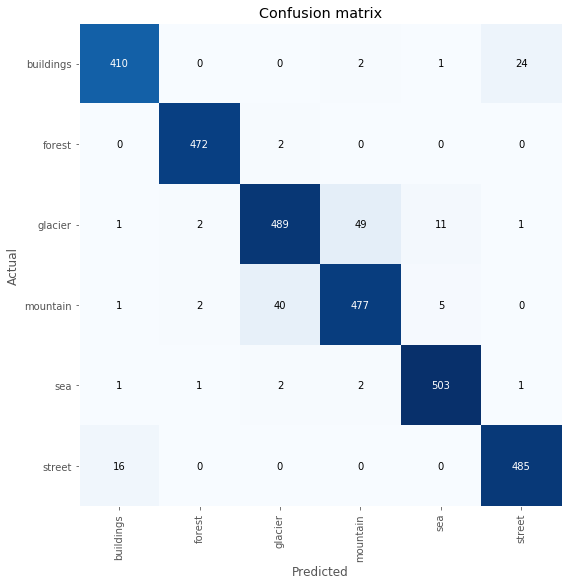

In [47]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(8,8))

In [48]:
del learner
gc.collect()

12828

In [49]:
new_databunch_4 = ImageDataBunch.from_folder(Path('../input'), ds_tfms=get_transforms(),
                               train='seg_train', valid='seg_test',
                                   size=150, bs=256).normalize(imagenet_stats)

new_databunch_4.add_test(test_img)

epoch,train_loss,valid_loss,accuracy,time
0,0.781420,0.296990,0.894333,01:11
1,0.404921,0.230307,0.916000,01:10
2,0.283196,0.278590,0.895000,01:10
3,0.226238,0.201436,0.930000,01:10
4,0.194896,0.273533,0.906000,01:11
5,0.167815,0.248328,0.911667,01:12
6,0.139884,0.189922,0.932333,01:09
7,0.115255,0.182985,0.936667,01:10
8,0.096687,0.176198,0.937333,01:10
9,0.086695,0.175362,0.940333,01:12


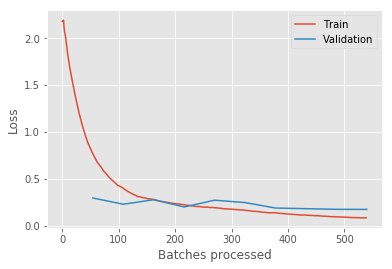

In [50]:
learner = cnn_learner(new_databunch_4, models.resnet101, metrics=accuracy, model_dir='/tmp/models').to_fp16()
learner.fit_one_cycle(10, max_lr=slice(1e-02, 1e-03))
learner.recorder.plot_losses()

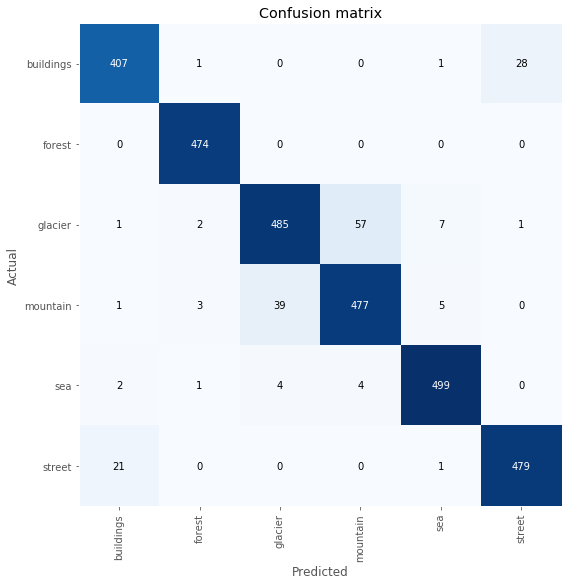

In [51]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(8,8))

Ensembling the last two models will definitely help. 